## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import metrics
import datetime

## Loading data

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

In [3]:
features_and_target = pd.read_csv('data/features_and_target.csv', parse_dates=['day'], index_col='day',date_parser=dateparse)

## Encode Shift

In [4]:
shift = pd.get_dummies(features_and_target['shift'])

In [5]:
features_and_target['ES'] = shift.ES
features_and_target['MS'] = shift.MS
features_and_target = features_and_target.drop('shift', axis=1)

## Train Test Validation Split
#### 253 Tage = 80/20 = 202/51 -> Split at 2018-06-28

In [6]:
train_test = features_and_target[:'2018-06-28']
validation = features_and_target['2018-06-28':]

In [7]:
train = train_test[:'2018-05-19']
test = train_test['2018-05-19':]

In [8]:
y = train['num_pickups'].values
train = train.drop('num_pickups', axis=1)

In [9]:
y_test = test['num_pickups'].values
test = test.drop('num_pickups', axis=1)

In [10]:
y_val = validation['num_pickups'].values
val = validation.drop('num_pickups', axis=1)

## Train

In [11]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(train,y)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [12]:
predictions_train = model.predict(train)
error_train = metrics.mean_squared_error(predictions_train, y)
rmse_train = np.sqrt(error_train)
print(rmse_train)

19.453546223364558


## Test

In [13]:
predictions_test = model.predict(test)
error_test = metrics.mean_squared_error(predictions_test, y_test)
rmse_test = np.sqrt(error_test)
print(rmse_test)

20.46341867650073


## Baseline model: always return mean of labels
Models should perform better than this baseline example

In [14]:
from sklearn import metrics
baseline_predictions = [y.mean()] * len(test)
mse = metrics.mean_squared_error(y_test, baseline_predictions)
rmse = np.sqrt(mse)
print(rmse)

28.5982715726174


## Feature Importance Analysis

In [15]:
from sklearn.ensemble import RandomForestRegressor
# fit random forest model to see feature importance in this model
model_rf = RandomForestRegressor(max_depth= 3, n_estimators=3, min_samples_leaf=5, random_state=1)
model_rf.fit(train, y)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=3, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [16]:
feature_importances = pd.DataFrame(data= { 'feature_importance_values':
                                          model_rf.feature_importances_}, index=train.columns.values)
feature_importances.sort_values('feature_importance_values')

,feature_importance_values
pickups-1,0.000000
ES,0.000000
pickups-5,0.006235
MS,0.010323
pickups-2,0.024426
pickups-6,0.030703
pickups-7,0.034568
pickups-3,0.050110
mean_avail_area_of_day,0.213904
pickups-4,0.629730


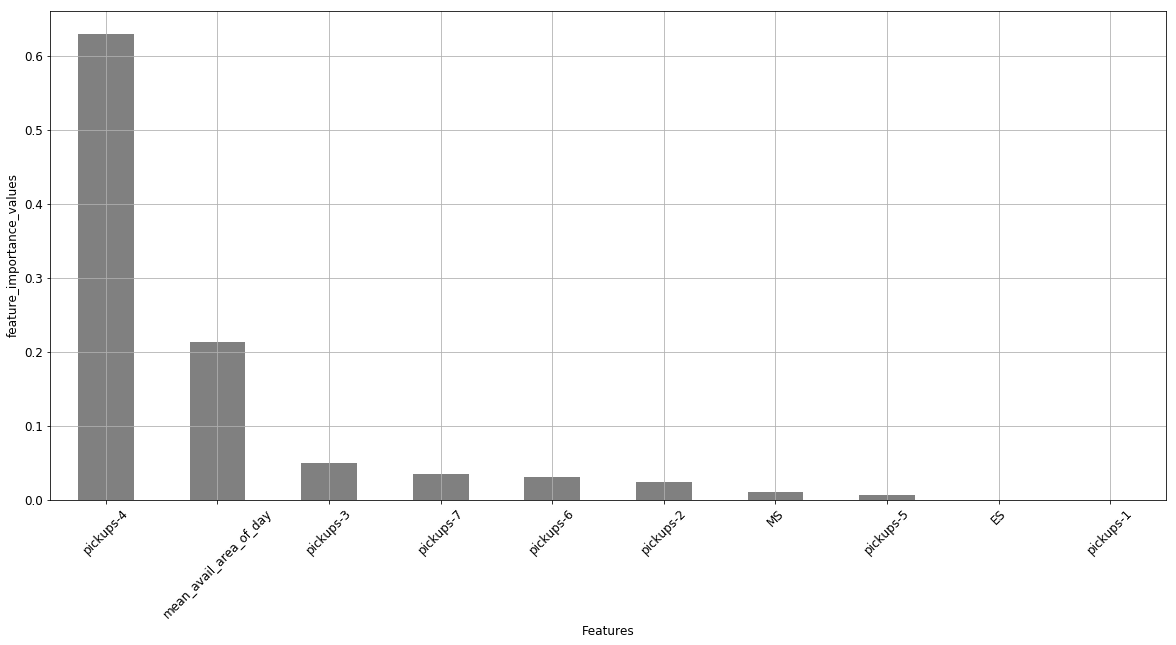

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
plot = feature_importances.feature_importance_values.sort_values(ascending=False).plot(capsize=5, legend=False, grid=True,color ='grey', kind='bar', figsize= (20,9))

for label in plot.get_xticklabels():
    label.set_rotation(45)

plot.set_ylabel('feature_importance_values')
plot.set_xlabel('Features')

plt.show()

## Predict 7 days from 2018-07-10 

### For Morning Shifts

In [18]:
ms_features_and_target = features_and_target[features_and_target['MS'] == 1]

In [19]:
ms_test_challenge = ms_features_and_target['2018-07-09':'2018-07-18']

In [20]:
last = ms_test_challenge['2018-07-09':'2018-07-09']
last = last.drop(columns=['num_pickups'])
last

,pickups-1,pickups-2,pickups-3,pickups-4,pickups-5,pickups-6,pickups-7,mean_avail_area_of_day,ES,MS
day,,,,,,,,,,
2018-07-09,59.0,36.0,67.0,59.0,84.0,60.0,118.0,0.30224,0,1


In [21]:
ms_forecasts = []
to_forecast = last

for i in range(1, 8):
    prediction = model.predict(to_forecast)
    ms_forecasts.append(prediction[0]) 
    to_forecast = to_forecast.shift(1, axis=1)
    to_forecast['pickups-1'] = prediction
    # fix shift errors
    to_forecast.mean_avail_area_of_day = last.mean_avail_area_of_day
    to_forecast.ES = last.ES
    to_forecast.MS = last.MS

In [22]:
ms_forecasts

[66.60891234168706,
 65.37182563810512,
 55.010325823722496,
 64.405464530177,
 69.17988990602807,
 68.09091763023963,
 62.05590882488656]

In [23]:
forecasts_ms = pd.DataFrame()
forecasts_ms['day'] = ms_features_and_target['2018-07-10':'2018-07-18'].index
forecasts_ms['forecast'] = ms_forecasts

In [24]:
forecasts_ms.to_csv('data/ms_forecasts.csv', index=False, header=True)

### For Evening Shifts

In [25]:
es_features_and_target = features_and_target[features_and_target['ES'] == 1]

In [26]:
es_test_challenge = es_features_and_target['2018-07-09':'2018-07-18']

In [27]:
es_test_challenge.head(10)

,num_pickups,pickups-1,pickups-2,pickups-3,pickups-4,pickups-5,pickups-6,pickups-7,mean_avail_area_of_day,ES,MS
day,,,,,,,,,,,
2018-07-09,57,30.0,44.0,43.0,70.0,31.0,73.0,35.0,0.443391,1,0
2018-07-11,26,57.0,30.0,44.0,43.0,70.0,31.0,73.0,0.333482,1,0
2018-07-16,64,26.0,57.0,30.0,44.0,43.0,70.0,31.0,0.609764,1,0
2018-07-18,30,64.0,26.0,57.0,30.0,44.0,43.0,70.0,0.396277,1,0


##  no continuous time series for evening shifts. predictions probably not useful with this model